In [2]:
#import gseapy as gp
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import omicverse as ov
import scvelo as scv
import anndata as ad
#from pyslingshot import Slingshot

/home/fengyu/miniconda3/envs/omicverse/lib/python3.10/site-packages/omicverse/utils/_data.py:329: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=600, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=600, vector_friendly=True)
vector(False)

In [4]:
from matplotlib.pyplot import rc_context
def marker_plot(adata, markers, binsize=1, save=None, vmax=None, vmin=None, zoom=1,
                use_raw=None, show=True, cmap=None, ncols=4):
    x, y = (adata.obsm['X_umap'].max(axis=0) - adata.obsm['X_umap'].min(axis=0))/binsize
    figsize = (zoom*x/16, zoom*y/20)
    with rc_context({'figure.figsize': figsize}):
        sc.pl.umap(adata, color=markers, save=save, show=show, size=2000*np.sqrt(x*y)/adata.shape[0], 
                   vmax=vmax, vmin=vmin, use_raw=use_raw, cmap=cmap, ncols=ncols)

In [4]:
import scanpy as sc
import pandas as pd

# 加载数据
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')

# 加载外部数据
df = pd.read_csv('/data1/fengyu/methods/fig8/bin50.Bcellclonesize.tsv', index_col=0)

# 保存原始索引
original_index = adata.obs.index

# 合并数据并填充缺失值
tmp = adata.obs.merge(df[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0)

# 恢复原始索引
tmp.index = original_index

# 更新 adata.obs
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']

In [5]:
for i in adata.obs.annotation.unique():
    tmp=adata[(adata.obs['annotation']==i)]
    print(i)
    print(tmp.obs['B_clone_expansion_n_cells'].value_counts())

Tumor
B_clone_expansion_n_cells
0.0    83979
1.0    72286
2.0     1231
3.0       32
4.0        1
Name: count, dtype: int64
Stroma
B_clone_expansion_n_cells
1.0    14187
0.0    10885
2.0      336
3.0       11
Name: count, dtype: int64
LA-myloid-aggregate
B_clone_expansion_n_cells
1.0    7250
0.0    5870
2.0     156
3.0       3
Name: count, dtype: int64
LA-TLS
B_clone_expansion_n_cells
1.0    2864
0.0    1518
2.0      94
3.0       3
4.0       3
Name: count, dtype: int64
LA-PCA
B_clone_expansion_n_cells
1.0    7949
0.0    3380
2.0     479
3.0      78
4.0      26
5.0       3
6.0       1
Name: count, dtype: int64
Alveolar
B_clone_expansion_n_cells
1.0    21382
0.0    19722
2.0      336
3.0        8
Name: count, dtype: int64
Ciliated
B_clone_expansion_n_cells
0.0    613
1.0    229
Name: count, dtype: int64


# Figure 6C

In [6]:
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
df = pd.read_csv('/data1/fengyu/methods/fig8/bin50.Bcellclonesize.tsv', index_col=0)

# 2. 合并数据，保持原有索引不变
adata.obs = adata.obs.merge(
    df[['loc', 'n_cells']],
    left_on='loc',
    right_on='loc',
    how='left'
)
adata.obs.index = adata.obs.index.astype(str)  # 保证索引类型一致
adata.obs['n_cells'] = adata.obs['n_cells'].fillna(0)

# 3. 添加新列并清理
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells'].astype(int).astype(str)
adata.obs.drop(columns=['n_cells'], inplace=True)

# 4. 画图前检查基因名，确保没有问题
genes = ['IGHM', 'IGHG1', 'IGHG3', 'IGHG4']
missing_genes = set(genes) - set(adata.var_names)
if missing_genes:
    print(f"Warning: the following genes are missing from adata.var_names: {missing_genes}")

In [7]:
adata = adata[adata.obs['annotation'].isin(['Stroma','LA-PCA','LA-TLS','LA-myloid-aggregate'])]

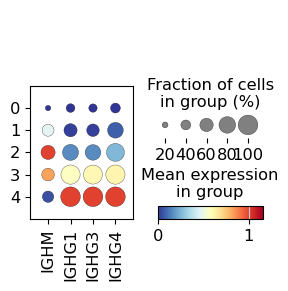

In [8]:
sel = adata.obs['B_clone_expansion_n_cells'].isin(['0', '1', '2', '3', '4'])

# Set the style to have a black background
with plt.style.context({'axes.facecolor': 'white', 'figure.facecolor': 'white'}):
    sc.pl.dotplot(
        adata[sel],
        genes,
        standard_scale='var',
        groupby='B_clone_expansion_n_cells',
        use_raw=False,
        cmap='RdYlBu_r',
        vmax=1.15,
        show=False
    )
    
    # Get current figure and modify axes
    fig = plt.gcf()
    for ax in fig.axes:
        ax.set_facecolor('white')
        # You might also want to set text and labels to white for visibility
        for text in ax.texts:
            text.set_color('black')
        ax.title.set_color('black')
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
    
    # Save with black background
    plt.savefig('Figure6C_dotplot.pdf', bbox_inches='tight', facecolor='black')
    plt.show()

# Figure 6D F

In [9]:
import scanpy as sc
import pandas as pd

# 加载数据
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
# 加载外部数据
df = pd.read_csv('/data1/fengyu/methods/fig8/bin50.Bcellclonesize.tsv', index_col=0)
original_index = adata.obs.index

# 合并数据并填充缺失值
tmp = adata.obs.merge(df[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0)

# 恢复原始索引
tmp.index = original_index

# 更新 adata.obs
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']

In [10]:
adata9=sc.read_h5ad('/data1/fengyu/methods/zy/P5_D06053D2_ananlysis/Latest_analysis_6.12/readid4/Final_D06053D2_after_processed_cellbin.h5ad')

In [11]:
D06053D2=adata[adata.obs.batch=='D06053D2'].copy()

In [12]:
adata9.obs['loc']='D06053D2_'+adata9.obs['bin50_x'].astype(str)+'_'+adata9.obs['bin50_y'].astype(str)
adata9.obs=adata9.obs.merge(D06053D2.obs[['loc','T_clone_expansion_n_cells','B_clone_expansion_n_cells']],on='loc',how='left')

In [13]:
D06053D2_stroma=D06053D2[D06053D2.obs['annotation'].isin(['Stroma','LA-PCA','LA-TLS','LA-myloid-aggregate'])]
D06053D2_stroma.obs['Bcellexpansion']='no'
D06053D2_stroma.obs.loc[D06053D2_stroma.obs['B_clone_expansion_n_cells']>=2,'Bcellexpansion']='yes'

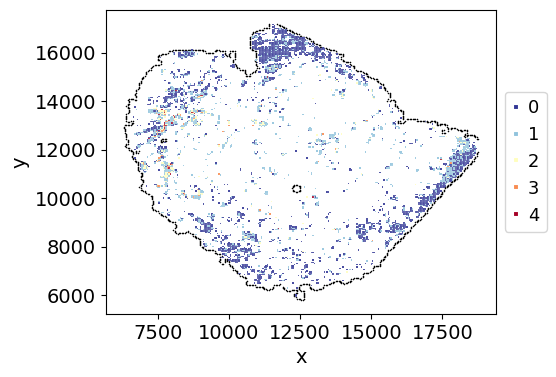

In [16]:
tissue_outline=pd.DataFrame(adata9.uns['tissue_outline'],columns=['x','y'])
#sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=3,edgecolor=None)
plt.figure(figsize=(5, 4))
plt.grid(False)
sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=1,edgecolor=None)
tmp=D06053D2_stroma.obs
tmp['B_clone_expansion_n_cells'] = tmp['B_clone_expansion_n_cells'].astype(int)
tmp.loc[tmp['B_clone_expansion_n_cells'].isin([4,5,6]),'B_clone_expansion_n_cells'] =  4
sns.scatterplot(data=tmp,x='x',y='y',hue='B_clone_expansion_n_cells',palette='RdYlBu_r',s=1.1,marker='s')
#tmp2=Tcell[Tcell.obs['batch']==i].obs
#sns.scatterplot(data=tmp2[(~tmp2['TRBcdr3aa'].isin(ls))&((tmp2['TRBcdr3aa'].notna()))],x='x',y='y',hue='anno2',palette='tab20',s=5)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),markerscale=3)
#plt.savefig('Figure6B_left.pdf',dpi = 600)

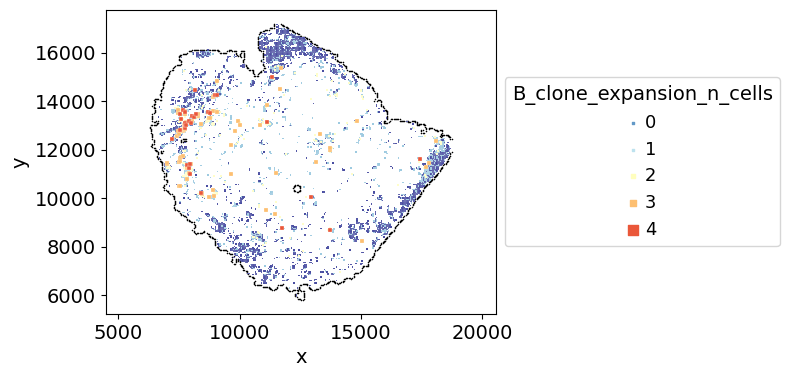

In [17]:
plt.figure(figsize=(5, 4))
plt.grid(False)
tissue_outline=pd.DataFrame(adata9.uns['tissue_outline'],columns=['x','y'])
#sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=3,edgecolor=None)
# 1) 背景轮廓
sns.scatterplot(data=tissue_outline,
                x='x', y='y',
                color='black', s=1, edgecolor=None)

# 2) 统一画所有点（小尺寸）
g = sns.scatterplot(data=tmp,
                    x='x', y='y',
                    hue='B_clone_expansion_n_cells',
                    palette='RdYlBu_r',
                    s=1.1, marker='s')

# 3) 把 2, 3, 4 的点再画一遍，放大且不加图例
palette = sns.color_palette('RdYlBu_r',
                            n_colors=tmp['B_clone_expansion_n_cells'].nunique())
lut = dict(zip(sorted(tmp['B_clone_expansion_n_cells'].unique()), palette))

# 调整点的大小：
for val in [2, 3, 4]:
    if val == 2:
        s = 3  # 2的点稍大
    elif val == 3:
        s = 5  # 3的点更大
    elif val == 4:
        s = 7  # 4的点最大
    
    sns.scatterplot(data=tmp[tmp['B_clone_expansion_n_cells'] == val],
                    x='x', y='y',
                    color=lut[val],
                    s=s, marker='s',
                    legend=False)

# 4) 自己构造新的图例（调整图例点的大小）
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

new_handles = []
for h, lab in zip(handles, labels):
    try:
        lab_int = int(lab)
        if lab_int == 2:
            new_h = ax.scatter([], [], color=lut[lab_int], s=3**2, marker='s', label=lab)
        elif lab_int == 3:
            new_h = ax.scatter([], [], color=lut[lab_int], s=5**2, marker='s', label=lab)
        elif lab_int == 4:
            new_h = ax.scatter([], [], color=lut[lab_int], s=7**2, marker='s', label=lab)
        else:
            new_h = ax.scatter([], [], color=lut[lab_int], s=1.1**2, marker='s', label=lab)
        new_handles.append(new_h)
    except ValueError:
        new_handles.append(h)

ax.legend(new_handles, labels,
          title='B_clone_expansion_n_cells',
          loc="center left",
          bbox_to_anchor=(1, 0.5))
plt.axis('equal')

plt.savefig('Figure6D.png', dpi=600)

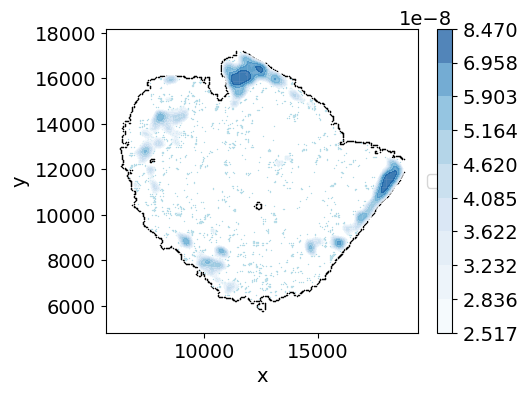

In [19]:
tissue_outline=pd.DataFrame(adata9.uns['tissue_outline'],columns=['x','y'])
#sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=3,edgecolor=None)
plt.figure(figsize=(5, 4))
plt.grid(False)
sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=1,edgecolor=None)
tmp=D06053D2_stroma.obs
tmp['B_clone_expansion_n_cells']=tmp['B_clone_expansion_n_cells'].astype(float)
sns.scatterplot(data=tmp[tmp['B_clone_expansion_n_cells']<2],x='x',y='y',color='lightblue',s=1)
sns.kdeplot(data=tmp[tmp['B_clone_expansion_n_cells']<2], x='x', y='y', fill=True, cmap='Blues', bw_adjust=0.2,thresh=0.5, kernel='linear', cbar=True,cut=0.2,alpha=0.7)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),markerscale=3)
plt.axis('equal')
plt.savefig('Figure6F1.png',dpi = 600)

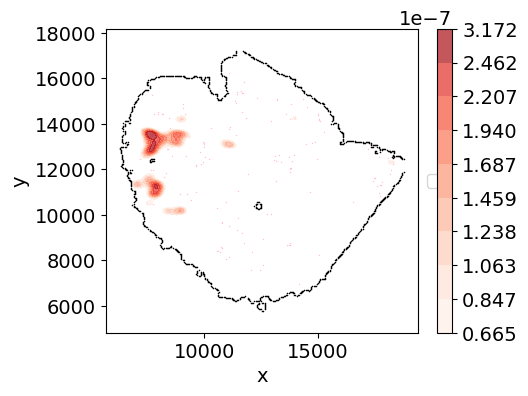

In [20]:
tissue_outline=pd.DataFrame(adata9.uns['tissue_outline'],columns=['x','y'])
#sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=3,edgecolor=None)
plt.figure(figsize=(5, 4))
plt.grid(False)
sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=1,edgecolor=None)
tmp=D06053D2_stroma.obs
tmp['B_clone_expansion_n_cells']=tmp['B_clone_expansion_n_cells'].astype(float)
sns.scatterplot(data=tmp[tmp['B_clone_expansion_n_cells']>=2],x='x',y='y',color='pink',s=1)
sns.kdeplot(data=tmp[tmp['B_clone_expansion_n_cells']>=2], x='x', y='y', fill=True, cmap='Reds', bw_adjust=0.2,thresh=0.5, kernel='linear', cbar=True,cut=0.2,alpha=0.7)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),markerscale=3)
plt.axis('equal')
plt.savefig('Figure6F2.png',dpi = 600)

# Figure 6E

In [21]:
import scanpy as sc
adata1 = sc.read_h5ad('/data1/fengyu/methods/zy/D06047A2/combine_3_meta/Final_D06047A2_after_processed_withThree_meta.h5ad')
adata2 = sc.read_h5ad('/data1/fengyu/methods/zy/D06047C3/combine_3_meta/Final_D06047C3_after_processed_withThree_meta.h5ad')
adata3 = sc.read_h5ad('/data1/fengyu/methods/zy/D06047D4/combine_3_meta/Final_D06047D4_after_processed_withThree_meta.h5ad')
adata4 = sc.read_h5ad('/data1/fengyu/methods/zy/D06047E1/combine_3_meta/Final_D06047E1_after_processed_withThree_meta.h5ad')
adata5 = sc.read_h5ad('/data1/fengyu/methods/zy/D06047E2/combine_3_meta/Final_D06047E2_after_processed_withThree_meta.h5ad')
adata6 = sc.read_h5ad('/data1/fengyu/methods/zy/D06047F6/combine_3_meta/Final_D06047F6_after_processed_withThree_meta.h5ad')
adata7 = sc.read_h5ad('/data1/fengyu/methods/zy/D06050A2/combine_3_meta/Final_D06050A2_after_processed_withThree_meta.h5ad')
adata8 = sc.read_h5ad('/data1/fengyu/methods/zy/D06050C2/combine_3_meta/Final_D06050C2_after_processed_withThree_meta.h5ad')
adata9 = sc.read_h5ad('/data1/fengyu/methods/zy/D06050D4/with_3_meta/Final_D06050D4_after_processed_withThree_meta.h5ad')
adata10 = sc.read_h5ad('/data1/fengyu/methods/zy/D06050E4/with_3_meta/Final_D06050E4_after_processed_withThree_meta.h5ad')
adata11 = sc.read_h5ad('/data1/fengyu/methods/zy/P5_D06053D2_ananlysis/Latest_analysis_6.12/readid4/Final_D06053D2_after_processed_cellbin.h5ad')

# 确保变量名唯一
adata_list = [adata1, adata2, adata3, adata4, adata5, adata6, adata7, adata8, adata9, adata10, adata11]
for adata in adata_list:
    adata.var_names_make_unique()

# 合并数据
batch_categories = ["D06047A2", "D06047C3", "D06047D4", "D06047E1", "D06047E2", "D06047F6", "D06050A2", "D06050C2", "D06050D4", "D06050E4", "D06053D2"]
adata = adata1.concatenate(adata_list[1:], batch_key="batch", batch_categories=batch_categories)

# 确保观测名是字符串类型
adata.obs_names = adata.obs_names.astype(str)

In [22]:
meta=pd.read_csv('/data1/fengyu/methods/fig5/LA_bin50_meta.csv',index_col=0)
adata.obs['loc']=adata.obs['batch'].astype(str)+'_'+adata.obs['bin50_x'].map(str)+'_'+adata.obs['bin50_y'].map(str)
adata.obs=adata.obs.merge(meta[['loc','LA_anno']],on='loc',how='left')

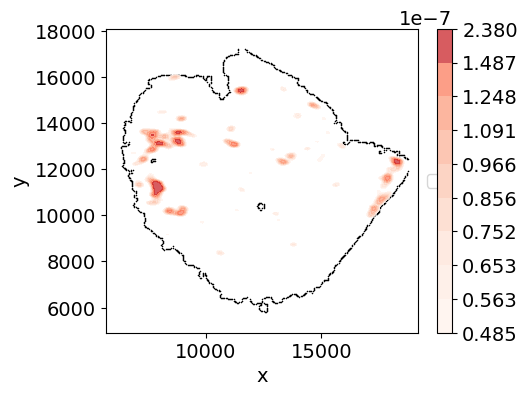

In [24]:
tissue_outline=pd.DataFrame(adata11.uns['tissue_outline'],columns=['x','y'])
#sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=3,edgecolor=None)
plt.figure(figsize=(5, 4))
plt.grid(False)
sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=1,edgecolor=None)
tmp= adata.obs[adata.obs['batch'] == 'D06053D2']
tmp['LA_anno']=tmp['LA_anno'].astype(str)
plt.axis('equal')
sns.kdeplot(data=tmp[tmp['LA_anno'] == 'PCA_IGHG/A' ], x='x', y='y', fill=True, cmap='Reds', bw_adjust=0.2,thresh=0.5, kernel='linear',cbar=True,alpha=0.7)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),markerscale=3)
plt.savefig('Figure6E.png',dpi = 600)

# Figure 6H

In [25]:
import scanpy as sc
adata11 = sc.read_h5ad('/data1/fengyu/methods/zy/P5_D06053D2_ananlysis/Latest_analysis_6.12/readid4/Final_D06053D2_after_processed_cellbin.h5ad')

In [26]:
adata9 = adata11[adata11.obs['anno2'].isin(['fibro_INHBA','macrophage','plasma_cell'])]

In [27]:
df = adata11[adata11.obs['anno2'].isin(['fibro_INHBA','macrophage','plasma_cell'])]

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


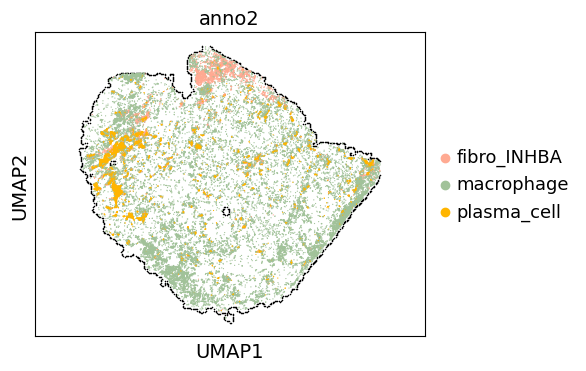

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc

fig, ax = plt.subplots(figsize=(5, 4))
plt.grid(False)

# 画 tissue outline
tissue_outline = pd.DataFrame(adata11.uns['tissue_outline'], columns=['x', 'y'])
sns.scatterplot(
    data=tissue_outline,
    x='x', y='y',
    color='black', s=1, edgecolor=None, ax=ax
)
plt.axis('equal')
# 保存当前的x、y范围
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 画 UMAP，不show，画在 ax 上
sc.pl.umap(
    df,
    color='anno2',
    groups=['fibro_INHBA', 'macrophage', 'plasma_cell'],
    palette={
        'fibro_INHBA': '#FFAA92',
        'macrophage': '#A1C299',
        'plasma_cell': '#FFB500'
    },
    s=3,
    ax=ax,
    show=False
)

# 恢复原来的坐标范围，保证 outline 的比例不变
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [31]:
array_2d = adata11.obsm['cell_border'].reshape(-1, adata11.obsm['cell_border'].shape[-1])

# 创建 DataFrame
df = pd.DataFrame(array_2d)
df['cellID'] = df.index // 32
df['cellID']=df['cellID'].astype(int)
df.rename(columns={0:'x',1:'y'}, inplace=True)
df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)]
df_filtered = pd.merge(df_filtered, adata11.obs[['x','y','cellID']], on='cellID', how='left')
df_filtered['x']=df_filtered['x_x']+df_filtered['x_y']
df_filtered['y']=df_filtered['y_x']+df_filtered['y_y']
df_cellborder=df_filtered[['cellID','x','y']]

In [32]:
cell_list = adata9.obs['cellID'].astype(int).tolist()
df_cellborder  = df_cellborder[df_cellborder['cellID'].isin(cell_list)]
plasma_list = adata9.obs[adata9.obs['anno2'] == 'plasma_cell']['cellID'].tolist()
macrophage_list = adata9.obs[adata9.obs['anno2'] == 'macrophage']['cellID'].tolist()
fibro_INHBA_list = adata9.obs[adata9.obs['anno2'] == 'fibro_INHBA']['cellID'].tolist()

In [33]:
plasma_cell_border = df_cellborder[df_cellborder['cellID'].isin(plasma_list)]
macrophage_cell_border = df_cellborder[df_cellborder['cellID'].isin(macrophage_list)]
fibro_cell_border = df_cellborder[df_cellborder['cellID'].isin(fibro_INHBA_list)]

In [34]:
plasma_cell_border_list = plasma_cell_border.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
filtered_cell_borders_list1 = plasma_cell_border_list
# 将每个细胞的坐标转换为 NumPy 数组
filtered_cell_borders_list1 = [np.array(cell) for cell in filtered_cell_borders_list1]
filtered_cell_borders_list1[0]

array([[12205,  6287],
       [12197,  6279],
       [12191,  6284],
       [12180,  6284],
       [12165,  6289],
       [12159,  6302],
       [12169,  6314],
       [12173,  6314],
       [12190,  6306],
       [12205,  6305],
       [12208,  6303],
       [12208,  6293]])

In [35]:
macrophage_cell_border_list = macrophage_cell_border.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
filtered_cell_borders_list2 = macrophage_cell_border_list
# 将每个细胞的坐标转换为 NumPy 数组
filtered_cell_borders_list2 = [np.array(cell) for cell in filtered_cell_borders_list2]
filtered_cell_borders_list2[0]

array([[12377,  5980],
       [12375,  5980],
       [12367,  5987],
       [12363,  5993],
       [12363,  6004],
       [12378,  6004],
       [12383,  6000],
       [12384,  5998],
       [12384,  5989],
       [12382,  5985]])

In [36]:
fibro_cell_border_list = fibro_cell_border.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
filtered_cell_borders_list3 = fibro_cell_border_list
# 将每个细胞的坐标转换为 NumPy 数组
filtered_cell_borders_list3 = [np.array(cell) for cell in filtered_cell_borders_list3]
filtered_cell_borders_list3[0]

array([[12250,  6340],
       [12245,  6339],
       [12241,  6342],
       [12236,  6342],
       [12242,  6348],
       [12242,  6349],
       [12243,  6350],
       [12244,  6350],
       [12246,  6348],
       [12247,  6348],
       [12247,  6347],
       [12249,  6345],
       [12249,  6344],
       [12250,  6343],
       [12251,  6343],
       [12251,  6341]])

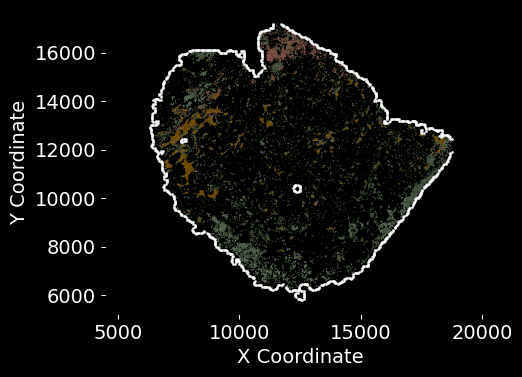

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from scipy.interpolate import splprep, splev
import seaborn as sns

plasma_color = '#FFB500'
macro_color = '#A1C299'
fibro_color = '#FFAA92'
BG_COLOR = 'black'     # 画布底色
TXT_COLOR = 'white'    # 文字颜色（与背景反色）

fig, ax = plt.subplots(figsize=(5,4))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

# -------------------------------------------------
# 3. 绘制散点
# -------------------------------------------------
#ax.scatter(data_GA['x'], data_GA['y'],color=GA_COLOR, s=0.05, marker='s', rasterized=True)
#ax.scatter(data_GM['x'], data_GM['y'],color=GM_COLOR, s=0.05, marker='s', rasterized=True)

# -------------------------------------------------
# 4. 平滑边界并生成 Path 补丁
# -------------------------------------------------
def smooth_boundary(boundary, smoothness=0.5):
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

patches = []
for cell_boundary in filtered_cell_borders_list1:
    if len(cell_boundary) < 3:
        continue
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             #edgecolor = 'white',
                             facecolor= plasma_color,
                             lw = 0.05,
                             antialiased=True))

for cell_boundary in filtered_cell_borders_list2:
    if len(cell_boundary) < 3:
        continue
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             # edgecolor = 'white',
                             facecolor=macro_color,
                             lw = 0.05,
                             antialiased=True))
    
for cell_boundary in filtered_cell_borders_list3:
    if len(cell_boundary) < 3:
        continue
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             #edgecolor = 'white',
                             facecolor=fibro_color,
                             lw = 0.05,
                             antialiased=True))

ax.add_collection(PatchCollection(patches, match_original=True))

# -------------------------------------------------
# 5. 绘制组织轮廓（可选）
# -------------------------------------------------
sns.scatterplot(data=tissue_outline, x='x', y='y',
                color='white', s=3, edgecolor=None, ax=ax)

# -------------------------------------------------
# 6. 图例、坐标轴、保存
# -------------------------------------------------
'''
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='GM',
           markerfacecolor=GM_COLOR, markersize=8, lw=0),
    Line2D([0], [0], marker='s', color='w', label='GA',
           markerfacecolor=GA_COLOR, markersize=8, lw=0)
]
'''
'''
legend = ax.legend(handles=legend_elements,
                   loc='upper right',
                   frameon=True,
                   framealpha=0.9,
                   facecolor=BG_COLOR,
                   edgecolor=TXT_COLOR,
                   fontsize=8,
                   title_fontsize=10)
plt.setp(legend.get_texts(), color=TXT_COLOR)
'''
ax.set_xlabel("X Coordinate", color=TXT_COLOR)
ax.set_ylabel("Y Coordinate", color=TXT_COLOR)
ax.tick_params(axis='both', colors=TXT_COLOR)
ax.grid(False)

plt.grid(False)
plt.axis('equal')
plt.savefig('fig6h1_zoomin.png',
            dpi=2500,               # 2500 太大，600 已足够
            bbox_inches='tight',
            facecolor=BG_COLOR,
            edgecolor='none')
plt.show()

In [39]:
adata9 = adata11[adata11.obs['anno2'].isin(['CD8_CXCL13','monocytes','plasma_cell'])]
df = adata11[adata11.obs['anno2'].isin(['CD8_CXCL13','plasma_cell'])]

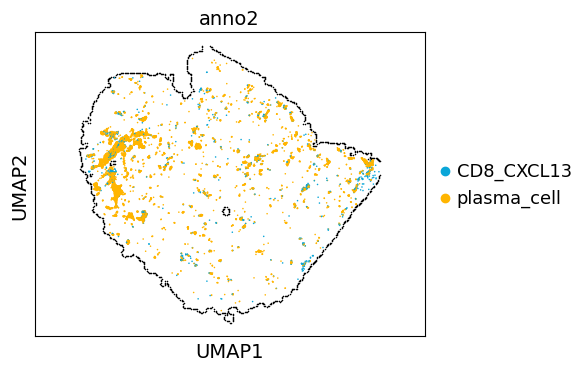

In [40]:
fig,ax = plt.subplots(figsize=(5, 4))
plt.grid(False)
tissue_outline=pd.DataFrame(adata11.uns['tissue_outline'],columns=['x','y'])
plt.axis('equal')
sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=1,edgecolor=None,ax = ax)
sc.pl.umap(df,color=['anno2'],
           groups=['CD8_CXCL13','plasma_cell'],
               palette={
        'CD8_CXCL13': '#0AA6D8',
        'plasma_cell': '#FFB500'
    },
           s=5,ax = ax,save = 'figure6h_right.png')

In [41]:
array_2d = adata11.obsm['cell_border'].reshape(-1, adata11.obsm['cell_border'].shape[-1])

# 创建 DataFrame
df = pd.DataFrame(array_2d)
df['cellID'] = df.index // 32
df['cellID']=df['cellID'].astype(int)
df.rename(columns={0:'x',1:'y'}, inplace=True)
df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)]
df_filtered = pd.merge(df_filtered, adata11.obs[['x','y','cellID']], on='cellID', how='left')
df_filtered['x']=df_filtered['x_x']+df_filtered['x_y']
df_filtered['y']=df_filtered['y_x']+df_filtered['y_y']
df_cellborder=df_filtered[['cellID','x','y']]

In [42]:
cell_list = adata9.obs['cellID'].astype(int).tolist()
df_cellborder  = df_cellborder[df_cellborder['cellID'].isin(cell_list)]

In [43]:
plasma_list = adata9.obs[adata9.obs['anno2'] == 'plasma_cell']['cellID'].tolist()
CD8_list = adata9.obs[adata9.obs['anno2'] == 'CD8_CXCL13']['cellID'].tolist()
monocytes_list = adata9.obs[adata9.obs['anno2'] == 'monocytes']['cellID'].tolist()

In [44]:
plasma_cell_border = df_cellborder[df_cellborder['cellID'].isin(plasma_list)]
CD8_cell_border = df_cellborder[df_cellborder['cellID'].isin(CD8_list)]
monocytes_cell_border = df_cellborder[df_cellborder['cellID'].isin(monocytes_list)]

In [45]:
plasma_cell_border_list = plasma_cell_border.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
filtered_cell_borders_list1 = plasma_cell_border_list
# 将每个细胞的坐标转换为 NumPy 数组
filtered_cell_borders_list1 = [np.array(cell) for cell in filtered_cell_borders_list1]
filtered_cell_borders_list1[0]

array([[12205,  6287],
       [12197,  6279],
       [12191,  6284],
       [12180,  6284],
       [12165,  6289],
       [12159,  6302],
       [12169,  6314],
       [12173,  6314],
       [12190,  6306],
       [12205,  6305],
       [12208,  6303],
       [12208,  6293]])

In [46]:
CD8_cell_border_list = CD8_cell_border.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
filtered_cell_borders_list2 = CD8_cell_border_list
# 将每个细胞的坐标转换为 NumPy 数组
filtered_cell_borders_list2 = [np.array(cell) for cell in filtered_cell_borders_list2]
filtered_cell_borders_list2[0]

array([[11227,  6771],
       [11222,  6776],
       [11219,  6777],
       [11216,  6782],
       [11224,  6791],
       [11229,  6793],
       [11239,  6789],
       [11242,  6779],
       [11237,  6775]])

In [47]:
monocytes_cell_border_list = monocytes_cell_border.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
filtered_cell_borders_list3 = monocytes_cell_border_list
# 将每个细胞的坐标转换为 NumPy 数组
filtered_cell_borders_list3 = [np.array(cell) for cell in filtered_cell_borders_list3]
filtered_cell_borders_list3[0]

array([[12444,  6950],
       [12444,  6952],
       [12445,  6952],
       [12451,  6958],
       [12454,  6958],
       [12456,  6960],
       [12462,  6960],
       [12463,  6959],
       [12465,  6959],
       [12462,  6953],
       [12462,  6951],
       [12461,  6951],
       [12456,  6945],
       [12450,  6946]])

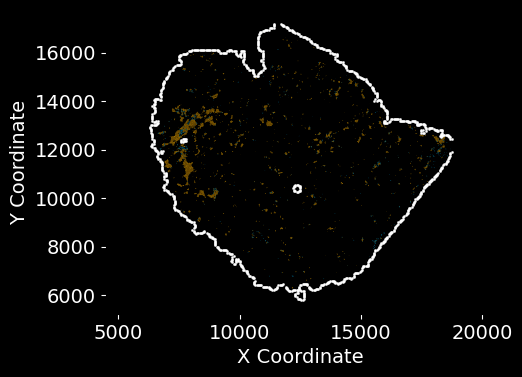

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from scipy.interpolate import splprep, splev
import seaborn as sns

plasma_color = '#FFB500'
#mono_color = '#0AA6D8'
CD8_color = '#0AA6D8'
BG_COLOR = 'black'     # 画布底色
TXT_COLOR = 'white'    # 文字颜色（与背景反色）

fig, ax = plt.subplots(figsize=(5,4))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

# -------------------------------------------------
# 3. 绘制散点
# -------------------------------------------------
#ax.scatter(data_GA['x'], data_GA['y'],color=GA_COLOR, s=0.05, marker='s', rasterized=True)
#ax.scatter(data_GM['x'], data_GM['y'],color=GM_COLOR, s=0.05, marker='s', rasterized=True)

# -------------------------------------------------
# 4. 平滑边界并生成 Path 补丁
# -------------------------------------------------
def smooth_boundary(boundary, smoothness=0.5):
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

patches = []
for cell_boundary in filtered_cell_borders_list1:
    if len(cell_boundary) < 3:
        continue
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             #edgecolor = 'white',
                             facecolor= plasma_color,
                             lw = 0.05,
                             antialiased=True))

for cell_boundary in filtered_cell_borders_list2:
    if len(cell_boundary) < 3:
        continue
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             # edgecolor = 'white',
                             facecolor=CD8_color,
                             lw = 0.05,
                             antialiased=True))
'''    
for cell_boundary in filtered_cell_borders_list3:
    if len(cell_boundary) < 3:
        continue
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             #edgecolor = 'white',
                             facecolor=CD8_color,
                             lw = 0.05,
                             antialiased=True))
'''
ax.add_collection(PatchCollection(patches, match_original=True))

# -------------------------------------------------
# 5. 绘制组织轮廓（可选）
# -------------------------------------------------
sns.scatterplot(data=tissue_outline, x='x', y='y',
                color='white', s=3, edgecolor=None, ax=ax)

# -------------------------------------------------
# 6. 图例、坐标轴、保存
# -------------------------------------------------
'''
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='GM',
           markerfacecolor=GM_COLOR, markersize=8, lw=0),
    Line2D([0], [0], marker='s', color='w', label='GA',
           markerfacecolor=GA_COLOR, markersize=8, lw=0)
]
'''
'''
legend = ax.legend(handles=legend_elements,
                   loc='upper right',
                   frameon=True,
                   framealpha=0.9,
                   facecolor=BG_COLOR,
                   edgecolor=TXT_COLOR,
                   fontsize=8,
                   title_fontsize=10)
plt.setp(legend.get_texts(), color=TXT_COLOR)
'''
ax.set_xlabel("X Coordinate", color=TXT_COLOR)
ax.set_ylabel("Y Coordinate", color=TXT_COLOR)
ax.tick_params(axis='both', colors=TXT_COLOR)
ax.grid(False)
plt.axis('equal')
plt.grid(False)
plt.savefig('fig6h2_zoomin.png',
            dpi=2500,               # 2500 太大，600 已足够
            bbox_inches='tight',
            facecolor=BG_COLOR,
            edgecolor='none')
plt.show()

# Figure 6I

In [49]:
import scanpy as sc
import pandas as pd

# 加载数据
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')

df = pd.read_csv('/data1/fengyu/methods/fig8/bin50.Bcellclonesize.tsv', index_col=0)

# 保存原始索引
original_index = adata.obs.index

# 合并数据并填充缺失值
tmp = adata.obs.merge(df[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0)

# 恢复原始索引
tmp.index = original_index

# 更新 adata.obs
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']

In [50]:
D06053D2=adata[adata.obs.batch=='D06053D2'].copy()

In [51]:
D06053D2_stroma=D06053D2[D06053D2.obs['annotation'].isin(['Stroma','LA-PCA','LA-TLS','LA-myloid-aggregate'])]
D06053D2_stroma.obs['Bcellexpansion']='no'
D06053D2_stroma.obs.loc[D06053D2_stroma.obs['B_clone_expansion_n_cells']>=2,'Bcellexpansion']='yes'
sc.pp.normalize_total(D06053D2_stroma, target_sum=1e4)
sc.pp.log1p(D06053D2_stroma)
sc.tl.rank_genes_groups(D06053D2_stroma, groupby='Bcellexpansion',method='t-test',use_raw=False,key_added='rank_yes_vs_no')

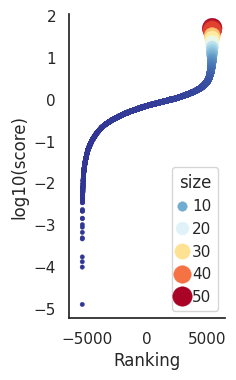

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
sns.set_theme(style="white")      # 全局白色背景
# 1. 读取差异分析结果
result = sc.get.rank_genes_groups_df(
    D06053D2_stroma,
    group='yes',
    key='rank_yes_vs_no'
)

# 2. 过滤 score < 0 的行，再取 log10
result = result[result['scores'] > 0].copy()
result['log10_score'] = np.log10(result['scores'])

# 3. 气泡大小仍用原始 score（已 > 0）
result['size'] = result['scores']

# 4. 生成 ranking（对称 0 轴）
result['ranking'] = np.arange(1, len(result) + 1)
result['ranking'] = len(result) / 2 - result['ranking']

# 5. 画图
plt.figure(figsize=(2, 4))
sns.scatterplot(
    data=result,
    x='ranking',
    y='log10_score',
    size='size',
    hue='size',
    palette='RdYlBu_r',
    edgecolor=None,
    sizes=(10, 200)
)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=2)
plt.xlim(-max(abs(result['ranking'])) * 1.2, max(abs(result['ranking'])) * 1.2)
plt.xlabel('Ranking')
plt.ylabel('log10(score)')
sns.despine()
plt.savefig('Figure6H.pdf', dpi=600, bbox_inches='tight')
plt.show()

# Figure 6G K

In [5]:
rna=sc.read_h5ad('/data1/fengyu/methods/scRNA/LUAD_GSE148071/luad_forcellbin.h5ad')

In [6]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

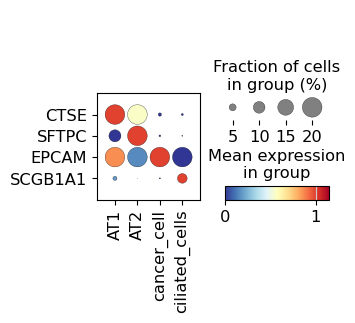

In [7]:
sc.pl.dotplot(rna[rna.obs.anno.isin(['epi','cancer_cell','ciliated_cells'])],var_names=[ 'CTSE', 'SFTPC','EPCAM','SCGB1A1'],
              groupby='anno2',standard_scale='var',swap_axes = True , 
              dot_max = 0.2, cmap = 'RdYlBu_r',vmax = 1.15,save = 'Sup10G1.pdf')

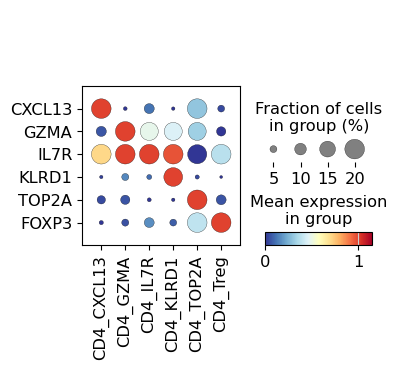

In [8]:
order=['CD4_CXCL13','CD4_GZMA','CD4_IL7R','CD4_KLRD1', 'CD4_TOP2A','CD4_Treg']
sc.pl.dotplot(rna[rna.obs.anno2.isin(order)],dot_max=0.2,swap_axes = True , 
              var_names=['CXCL13', 'GZMA', 'IL7R', 'KLRD1', 'TOP2A', 'FOXP3'],groupby='anno2',standard_scale='var',cmap = 'RdYlBu_r',vmax = 1.15,
             categories_order=order,save = 'Sup10G2.pdf')

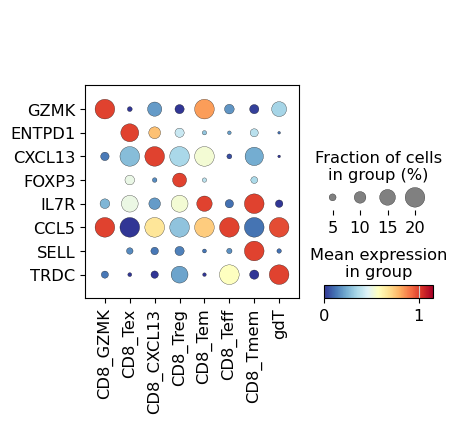

In [9]:
order=['CD8_GZMK','CD8_Tex','CD8_CXCL13','CD8_Treg', 'CD8_Tem','CD8_Teff','CD8_Tmem','gdT']
sc.pl.dotplot(rna[rna.obs.anno2.isin(order)],dot_max=0.2, cmap = 'RdYlBu_r',vmax = 1.15,swap_axes = True , 
              var_names=[ 'GZMK','ENTPD1','CXCL13','FOXP3','IL7R','CCL5','SELL','TRDC'],groupby='anno2',standard_scale='var',
             categories_order=order,save = 'Sup10G3.pdf')

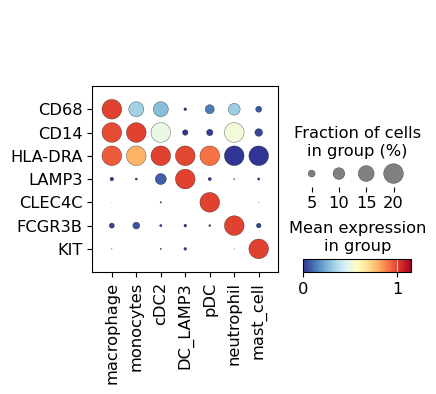

In [10]:
order=['macrophage', 'monocytes', 'cDC2', 'DC_LAMP3', 'pDC',  'neutrophil','mast_cell']
sc.pl.dotplot(rna[rna.obs.anno2.isin(order)],dot_max=0.2,var_names=['CD68','CD14','HLA-DRA','LAMP3','CLEC4C','FCGR3B','KIT']
              ,groupby='anno2',standard_scale='var',cmap = 'RdYlBu_r',swap_axes = True , vmax = 1.15,categories_order=order,save = 'Sup10G4.pdf')

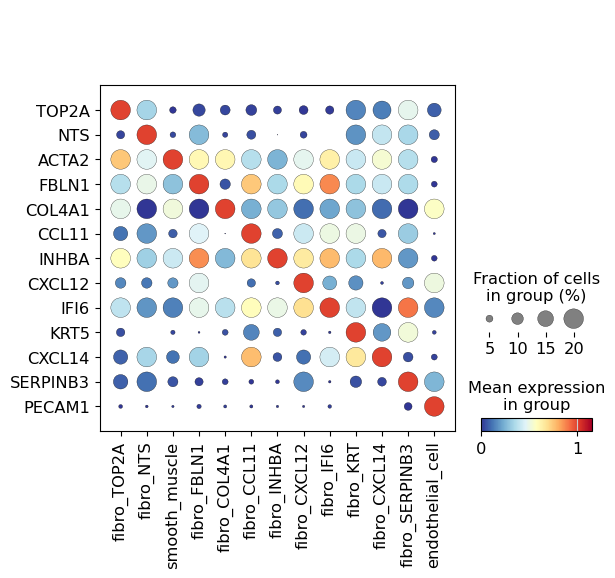

In [11]:
order=['fibro_TOP2A', 'fibro_NTS', 'smooth_muscle', 'fibro_FBLN1','fibro_COL4A1','fibro_CCL11',
       'fibro_INHBA','fibro_CXCL12', 'fibro_IFI6', 'fibro_KRT', 'fibro_CXCL14','fibro_SERPINB3','endothelial_cell',]
sc.pl.dotplot(rna[rna.obs.anno2.isin(order)],dot_max=0.2,swap_axes = True , 
              var_names=['TOP2A','NTS','ACTA2','FBLN1','COL4A1','CCL11','INHBA','CXCL12','IFI6','KRT5','CXCL14','SERPINB3','PECAM1'],groupby='anno2',standard_scale='var',cmap = 'RdYlBu_r',vmax = 1.15,
             categories_order=order,save = 'Sup10G5.pdf')

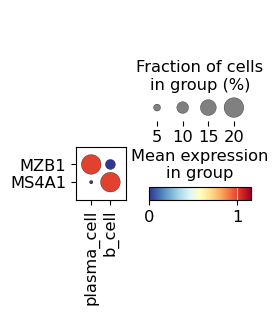

In [12]:
order=['plasma_cell','b_cell']
sc.pl.dotplot(rna[rna.obs.anno2.isin(order)],dot_max=0.2,
              var_names=['MZB1','MS4A1'],groupby='anno2',standard_scale='var',cmap = 'RdYlBu_r',vmax = 1.15,swap_axes = True , 
             categories_order=order,save = 'Sup10G6.pdf')

In [13]:
adata9=sc.read_h5ad('/data1/fengyu/methods/zy/P5_D06053D2_ananlysis/Latest_analysis_6.12/readid4/Final_D06053D2_after_processed_cellbin.h5ad')
cell=sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_cellbin.h5ad')

In [14]:
tmp=cell[:,['IGHG1','IGHG3','IGHG4']].to_df()
tmp['IgG']=tmp.sum(axis=1)
df=cell.obs
df['IgG']=tmp['IgG']
bs=200
df['bin200_x']=df['x']//bs*bs
df['bin200_y']=df['y']//bs*bs
df['loc']=df['batch'].astype(str)+'_'+df['bin200_x'].astype(str)+'_'+df['bin200_y'].astype(str)
df['anno2']=df['anno2'].astype(str)
df=df[df['anno']!='nan']

In [15]:
from scipy.stats import pearsonr
df = df[df['anno'].notna()]

target = 'plasma_cell'

# 2. 预计算：每个 batch 的宽表 ------------------------------------------
def corr_in_batch(sub_df):
    # 按 (x,y,anno) 计数 -> 宽表
    wide = (
        sub_df.groupby(['loc', 'anno2'])
              .size()
              .unstack(fill_value=0)
    )
    if target not in wide.columns:
        return pd.Series(dtype=float)  # 该 batch 没有 plasma_cell
    
    # 计算 plasma_cell 与其他类型的相关系数
    res = {}
    for ct in wide.columns:
        if ct == target:
            continue
        # 去掉两个向量都为 0 的坐标，减少稀疏噪声
        mask = (wide[target] + wide[ct]) > 0
        x = wide.loc[mask, target]
        y = wide.loc[mask, ct]
        if len(x) >= 3:
            r, _ = pearsonr(x, y)
            res[ct] = r
        else:
            res[ct] = np.nan
    return pd.Series(res)

# 3. 按 batch 分组计算 ---------------------------------------------------
corr_tbl = df.groupby('batch').apply(corr_in_batch).T   # 转置后行=batch, 列=细胞类型
# 期望的批次顺序
order = [
    'D06053D2', 'D06047C3', 'D06047F6', 'D06047E1', 'D06050A2',
    'D06047A2', 'D06050C2', 'D06047D4', 'D06047E2', 'D06050D4',
    'D06050E4'
]

# 只保留实际存在的批次，并保持指定顺序
corr_tbl = corr_tbl[order]      # 如果某些批次缺失会自动变成 NaN 列

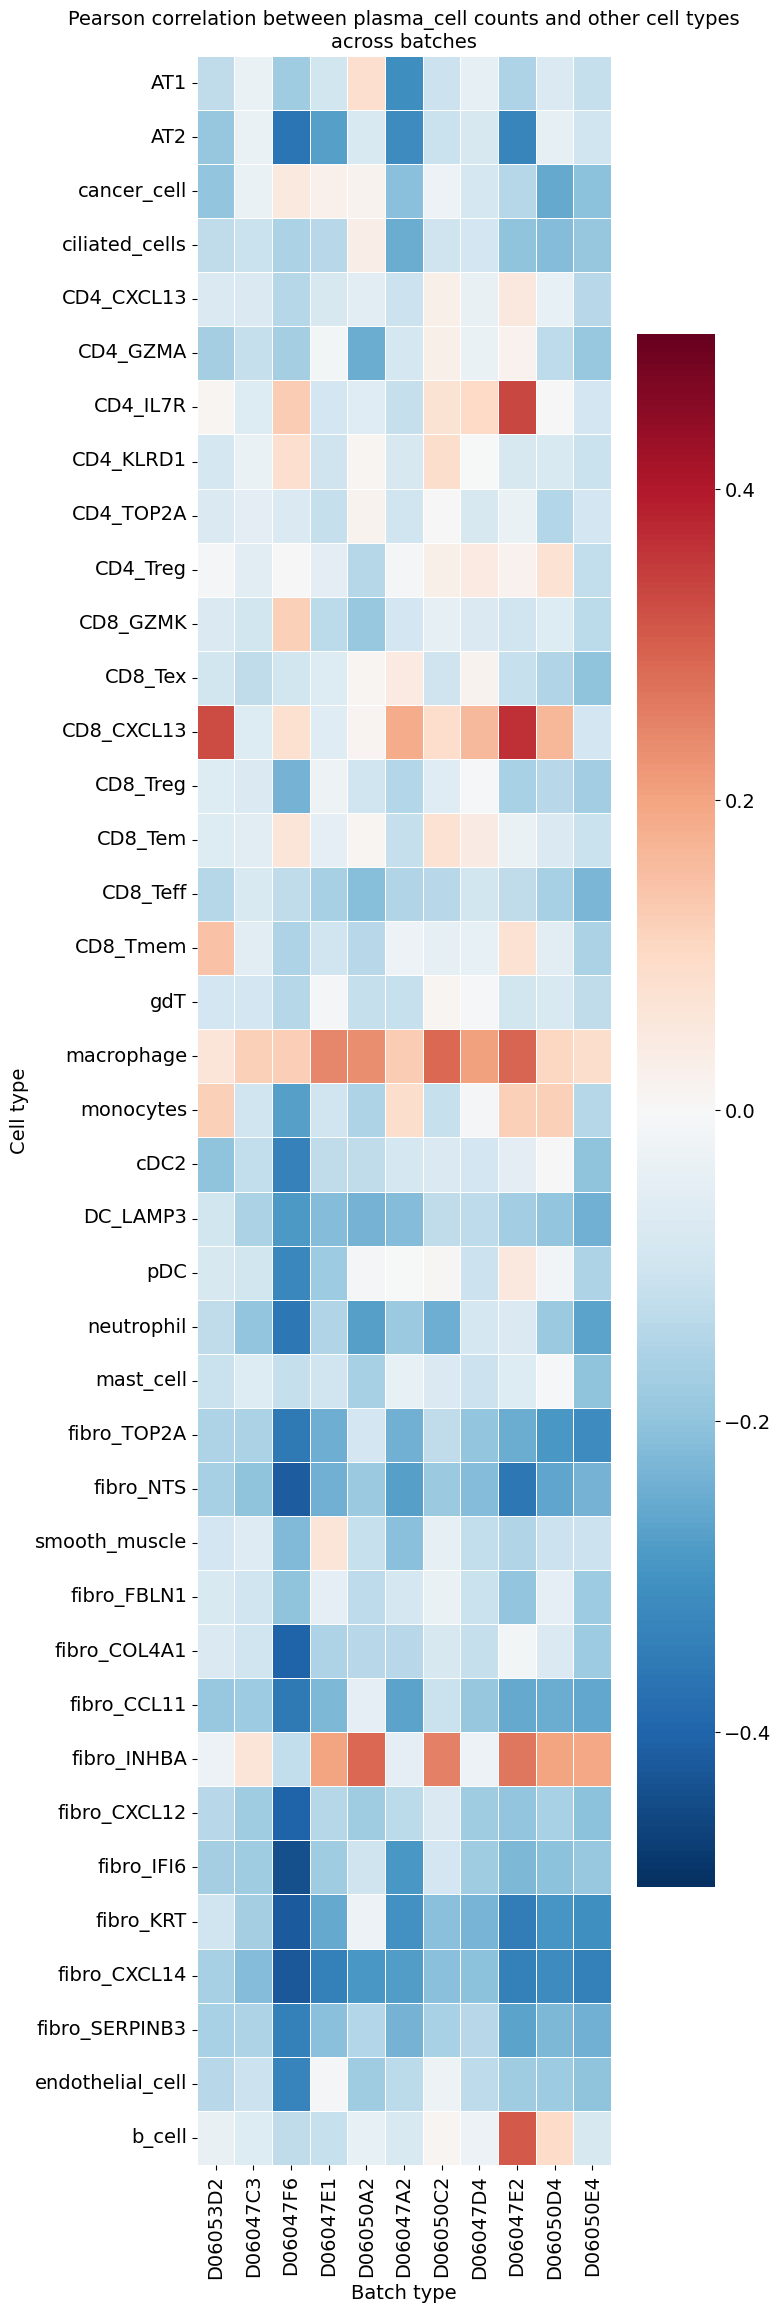

In [17]:
# ----------------- 重新排序 Y 轴 -----------------
order_list = [
    'AT1','AT2','cancer_cell','ciliated_cells',
    'CD4_CXCL13','CD4_GZMA','CD4_IL7R','CD4_KLRD1','CD4_TOP2A','CD4_Treg',
    'CD8_GZMK','CD8_Tex','CD8_CXCL13','CD8_Treg','CD8_Tem','CD8_Teff','CD8_Tmem','gdT',
    'macrophage','monocytes','cDC2','DC_LAMP3','pDC','neutrophil','mast_cell',
    'fibro_TOP2A','fibro_NTS','smooth_muscle','fibro_FBLN1','fibro_COL4A1',
    'fibro_CCL11','fibro_INHBA','fibro_CXCL12','fibro_IFI6','fibro_KRT',
    'fibro_CXCL14','fibro_SERPINB3','endothelial_cell',
    'plasma_cell','b_cell'
]

# 只保留在 order_list 中且存在于 corr_tbl 的行
corr_tbl = corr_tbl.reindex([ct for ct in order_list if ct in corr_tbl.index])

# ----------------- 画热图 -----------------
plt.figure(figsize=(max(8, corr_tbl.shape[1]*0.6),
                    max(6, corr_tbl.shape[0]*0.6)))
sns.heatmap(corr_tbl,
            annot=False,
            fmt='.2f',
            cmap='RdBu_r',
            vmin=-0.5, vmax=0.5,
            linewidths=.5)
plt.title('Pearson correlation between plasma_cell counts and other cell types\n'
          'across batches')
plt.xlabel('Batch type')
plt.ylabel('Cell type')
plt.tight_layout()
plt.grid(False)
plt.savefig('Figure10K.pdf')
plt.show()

<Figure size 1000x1000 with 0 Axes>

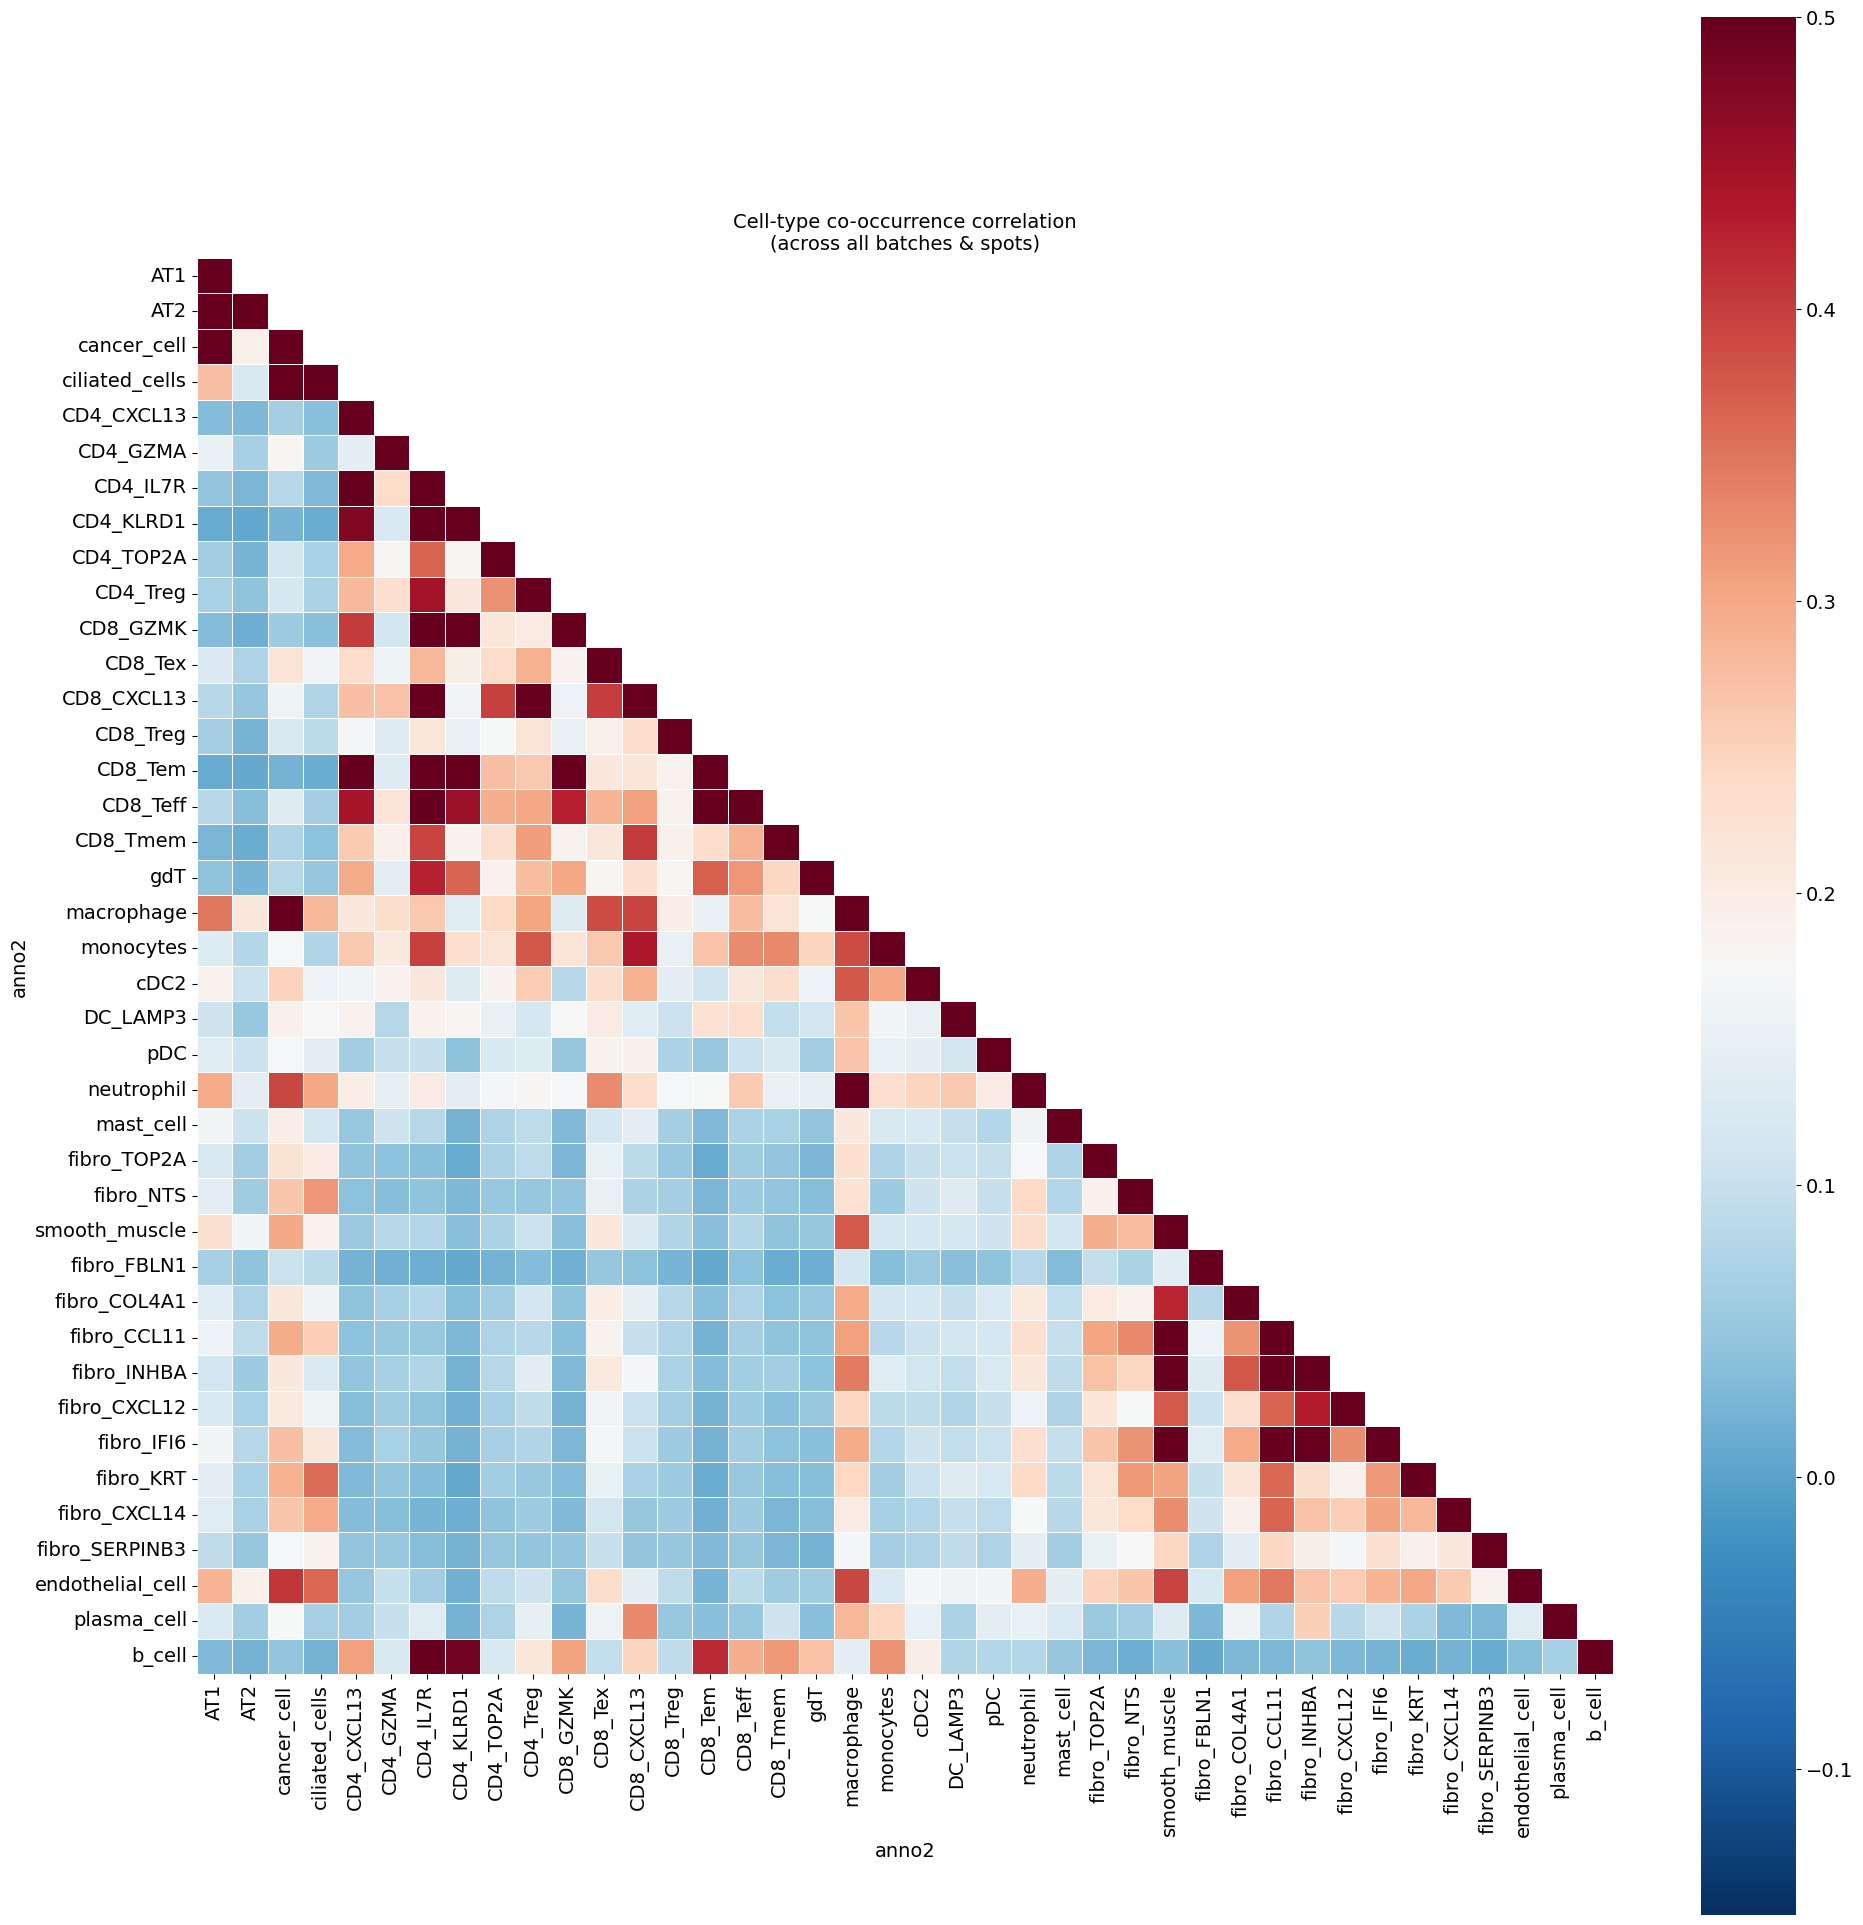

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define your desired order
order_list = ['AT1','AT2','cancer_cell','ciliated_cells',
              'CD4_CXCL13','CD4_GZMA','CD4_IL7R','CD4_KLRD1', 'CD4_TOP2A','CD4_Treg',
             'CD8_GZMK','CD8_Tex','CD8_CXCL13','CD8_Treg', 'CD8_Tem','CD8_Teff','CD8_Tmem','gdT',
             'macrophage', 'monocytes', 'cDC2', 'DC_LAMP3', 'pDC', 'myeloid_cell', 'neutrophil','mast_cell',
             'fibro_TOP2A', 'fibro_NTS', 'smooth_muscle', 'fibro_FBLN1','fibro_COL4A1', 'fibro_CCL11','fibro_INHBA','fibro_CXCL12', 'fibro_IFI6', 'fibro_KRT', 'fibro_CXCL14','fibro_SERPINB3','endothelial_cell',
             'plasma_cell','b_cell']

wide = (
    df.groupby(['batch', 'loc', 'anno2'])
      .size()
      .unstack(fill_value=0)
)    # index 是 MultiIndex(batch, x, y)

# 3. 计算相关矩阵 -------------------------------------------------------
corr_mat = wide.corr(method='pearson')   # DataFrame，行列均为细胞类型

# 2. Filter order_list to only include categories present in the correlation matrix
present_categories = [c for c in order_list if c in corr_mat.columns]
corr_mat = corr_mat.loc[present_categories, present_categories]

# 3. Create the triangular mask
mask = np.triu(np.ones_like(corr_mat, dtype=bool), k=1)

# 4. Plot with adjusted figure size
plt.figure(figsize=(max(8, len(present_categories)*0.5),
                   max(7, len(present_categories)*0.5)))

# 4. Plot with adjusted figure size
plt.figure(figsize=(max(8, len(present_categories)*0.5),
                   max(7, len(present_categories)*0.5)))


sns.heatmap(corr_mat,
            mask=mask,
            annot=False,
            fmt='.2f',
            cmap='RdBu_r',
            vmin=-0.15, vmax=0.5,
            linewidths=.5,
            square=True)

plt.title('Cell-type co-occurrence correlation\n(across all batches & spots)')
plt.tight_layout()
plt.grid(False)
plt.savefig('Figure6G.pdf')
plt.show()

# Figure 6J

In [20]:
import scanpy as sc
import pandas as pd

# 加载数据
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
# 加载外部数据
df = pd.read_csv('/data1/fengyu/methods/fig8/bin50.Bcellclonesize.tsv', index_col=0)

# 保存原始索引
original_index = adata.obs.index

# 合并数据并填充缺失值
tmp = adata.obs.merge(df[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0)

# 恢复原始索引
tmp.index = original_index

# 更新 adata.obs
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']

In [21]:
D06053D2=adata[adata.obs.batch=='D06053D2'].copy()
D06053D2_stroma=D06053D2[D06053D2.obs['annotation'].isin(['Stroma','LA-PCA','LA-TLS'])]
D06053D2_stroma.obs['Bcellexpansion']='no'
D06053D2_stroma.obs.loc[D06053D2_stroma.obs['B_clone_expansion_n_cells']>=2,'Bcellexpansion']='yes'
sc.pp.normalize_total(D06053D2_stroma, target_sum=1e4)
sc.pp.log1p(D06053D2_stroma)
sc.tl.rank_genes_groups(D06053D2_stroma, groupby='Bcellexpansion',method='t-test',use_raw=False,key_added='rank_yes_vs_no')

In [22]:
D06053D2_stroma.obs['B_clone_expansion_n_cells'] = D06053D2_stroma.obs['B_clone_expansion_n_cells'].astype(str)

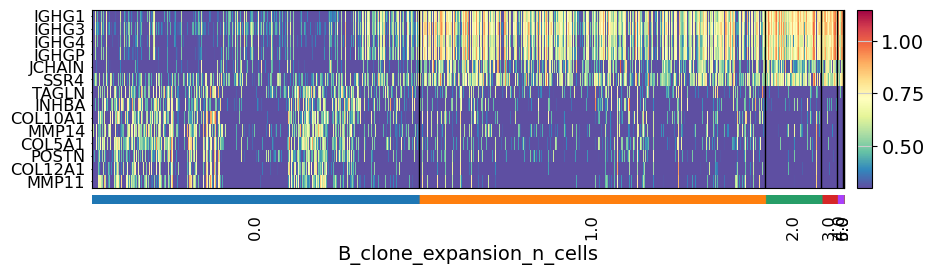

In [23]:
markers = ['IGHG1','IGHG3','IGHG4','IGHGP','JCHAIN','SSR4','TAGLN','INHBA','COL10A1','MMP14','COL5A1','POSTN','COL12A1','MMP11']
sc.pl.heatmap(D06053D2_stroma, markers, groupby='B_clone_expansion_n_cells', use_raw=False,swap_axes=True,
              standard_scale='var',cmap='Spectral_r',vmax=1.15,vmin=0.3,show = False)
plt.savefig('Figure6J.pdf',dpi = 600)

# Figure 6M

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import scvelo as scv
import anndata as ad
#import omicverse as ov
#import pcurvepy2        

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LUAD=sc.read_h5ad('/data1/fengyu/methods/validation/GSE207422.h5ad')
LUAD.var["mt"] = LUAD.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    LUAD, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pp.normalize_total(LUAD, target_sum=1e4)
sc.pp.log1p(LUAD)
sc.pp.highly_variable_genes(LUAD, min_mean=0.0125, max_mean=3, min_disp=0.5)
LUAD.raw = LUAD.copy()
sc.pp.scale(LUAD, max_value=10)
sc.tl.pca(LUAD, svd_solver="arpack")
sc.pp.neighbors(LUAD, n_neighbors=10, n_pcs=40)
sc.tl.umap(LUAD)
sc.tl.leiden(
    LUAD,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
LUAD.obs['Sample'].nunique()

15

In [14]:
LUAD

AnnData object with n_obs × n_vars = 92330 × 24292
    obs: 'cellID', 'Sample', 'Patient', 'Resource', 'Sex', 'Age', 'Clinical Stage', 'Pathology', 'PD1 Antibody', 'Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


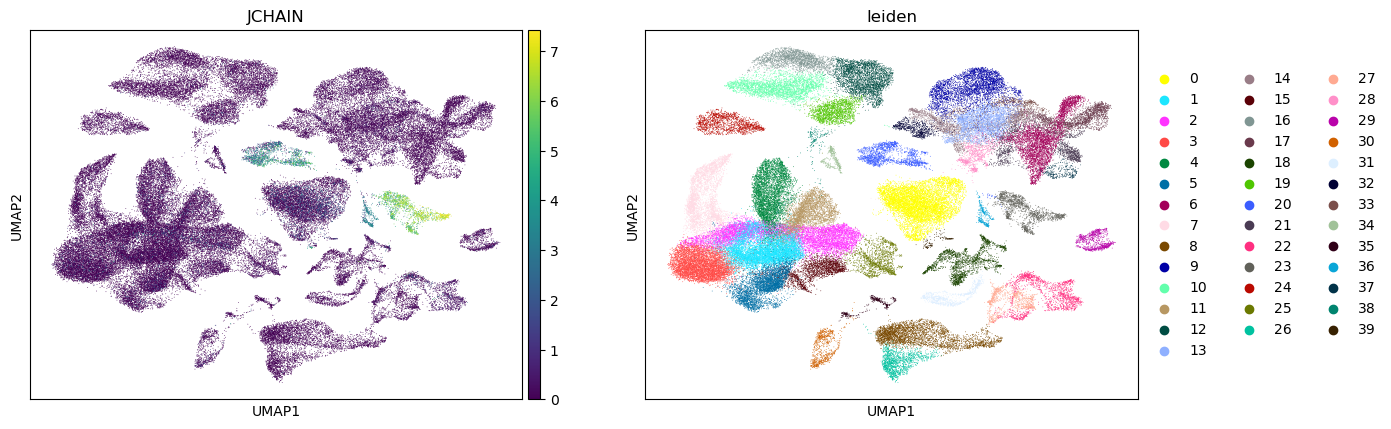

In [3]:
sc.pl.umap(LUAD, color=["JCHAIN", "leiden"])

/tmp/ipykernel_204154/233944427.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  fibro.obs['group']=fibro.obs['Resource'].astype(str)+'_'+fibro.obs['RECIST'].astype(str)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


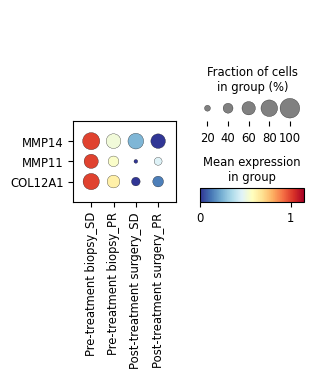

In [4]:
genes=['MMP14','MMP11','COL12A1']
order=['Pre-treatment biopsy_SD','Pre-treatment biopsy_PR','Post-treatment surgery_SD','Post-treatment surgery_PR' ]
fibro=LUAD[LUAD.obs['leiden'].isin(['30','35'])]
fibro.obs['group']=fibro.obs['Resource'].astype(str)+'_'+fibro.obs['RECIST'].astype(str)
sc.pl.dotplot(fibro,genes,standard_scale='var',vmax=1.15,
              groupby='group',swap_axes=True,cmap='RdYlBu_r',categories_order=order,dot_max = 1,save='fig6m_left.pdf')

In [5]:
fibro

AnnData object with n_obs × n_vars = 1122 × 24292
    obs: 'cellID', 'Sample', 'Patient', 'Resource', 'Sex', 'Age', 'Clinical Stage', 'Pathology', 'PD1 Antibody', 'Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'group'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/tmp/ipykernel_204154/534191070.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  plasmacell.obs['group']=plasmacell.obs['Resource'].astype(str)+'_'+plasmacell.obs['RECIST'].astype(str)


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


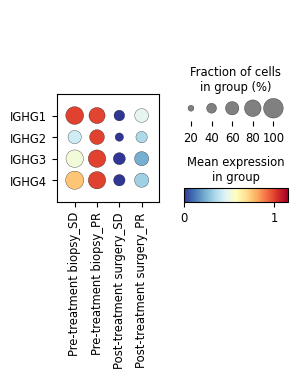

In [6]:
plasmacell=LUAD[LUAD.obs['leiden'].isin(['20','23','36','39'])]
plasmacell.obs['group']=plasmacell.obs['Resource'].astype(str)+'_'+plasmacell.obs['RECIST'].astype(str)
sc.pl.dotplot(plasmacell,['IGHG1','IGHG2','IGHG3','IGHG4'],standard_scale='var',
              groupby='group',swap_axes=True,cmap='RdYlBu_r',categories_order=order,vmax=1.15,save='fig6m_middle.pdf')

In [7]:
plasmacell

AnnData object with n_obs × n_vars = 3661 × 24292
    obs: 'cellID', 'Sample', 'Patient', 'Resource', 'Sex', 'Age', 'Clinical Stage', 'Pathology', 'PD1 Antibody', 'Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'group'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/tmp/ipykernel_204154/3062561266.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage.obs['group']=macrophage.obs['Resource'].astype(str)+'_'+macrophage.obs['RECIST'].astype(str)


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


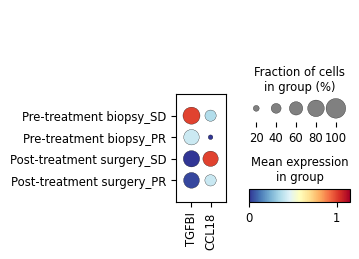

In [8]:
genes=['TGFBI','CCL18']
order=['Pre-treatment biopsy_SD','Pre-treatment biopsy_PR','Post-treatment surgery_SD','Post-treatment surgery_PR' ]
macrophage=LUAD[LUAD.obs['leiden'].isin(['6','9','13','15','17','21','28','32','33','37'])]
macrophage.obs['group']=macrophage.obs['Resource'].astype(str)+'_'+macrophage.obs['RECIST'].astype(str)
sc.pl.dotplot(macrophage,genes,standard_scale='var',vmax=1.15,dot_max = 1,
              groupby='group',cmap='RdYlBu_r',categories_order=order,save='fig6m_right.pdf')

In [9]:
macrophage

AnnData object with n_obs × n_vars = 18501 × 24292
    obs: 'cellID', 'Sample', 'Patient', 'Resource', 'Sex', 'Age', 'Clinical Stage', 'Pathology', 'PD1 Antibody', 'Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'group'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'